In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist
import numpy as np
import matplotlib.pyplot as plt


# Separazione di immagini

Questo progetto ha l'obiettivo di separare un'immagine, ottenuta come somma di due immagini, nelle sue componenti originali.

Le due immagini di origine, img1 e img2, provengono da dataset diversi: MNIST e Fashion-MNIST, rispettivamente.

Non è consentita alcuna pre-elaborazione. La rete neurale riceve in input l'immagine combinata (img1 + img2) e restituisce le predizioni (hat_img1 e hat_img2).

Le prestazioni vengono valutate utilizzando l'errore quadratico medio (MSE) tra le immagini predette e quelle di riferimento.

Entrambi i dataset (MNIST e Fashion-MNIST) sono in scala di grigi. Per semplicità, tutti i campioni vengono adattati alla risoluzione (32,32).

In [2]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
mnist_x_train = np.pad(mnist_x_train, ((0,0), (2,2), (2,2))) / 255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test, ((0,0), (2,2), (2,2))) / 255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train, ((0,0), (2,2), (2,2))) / 255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test, ((0,0), (2,2), (2,2))) / 255.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(60000, 28, 28)
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 32, 32)


#Generazione dei dati

In [3]:
def datagenerator(x1, x2, batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = (x1[num1], x2[num2])

        yield x_data, y_data

#Modello
Costruisce un modello di rete neurale che:
  - Utilizza immagini 32x32
  - Ha un encoder a blocchi con due convoluzioni ciascuno
  - Ha due decoder (uno per MNIST e uno per Fashion) con skip connections

Le **skip connections** sono collegamenti che passano direttamente informazioni dai livelli iniziali del modello ai livelli più profondi, evitando che vengano completamente perse durante il downsampling.

Il metodo di **He**, o **He Initialization**, è un metodo per inizializzare i pesi di una rete neurale in modo che il flusso del gradiente venga mantenuto stabile durante l'addestramento.
Quando una rete neurale viene creata, i pesi dei neuroni devono essere inizializzati con valori casuali. Un'inizializzazione sbagliata può causare problemi, come:
- Gradiente che esplode (i valori diventano troppo grandi).
- Gradiente che scompare (i valori diventano troppo piccoli, rendendo l'apprendimento lento o impossibile).

Perchè **LeakyReLU**?
Se utilzzassi ReLU alcuni neuroni possono "morire" e non aggiornare mai i loro pesi (smettono di apprendere).
LeakyReLU è una versione migliorata di ReLU, utile per evitare che alcuni neuroni diventino inattivi durante l'addestramento (neurono "morti": neuroni che smettono di apprendere).

Il **bottleneck** è la parte centrale della rete dove i dati vengono compressi prima della ricostruzione. Nel mio modello, serve per creare una rappresentazione compatta prima che i due decoder (MNIST e Fashion MNIST) ricostruiscano le immagini

In [4]:
def build_model():

    # Modifichiamo l'input a 32x32
    inputs = layers.Input(shape=(32, 32))
    x = layers.Reshape((32, 32, 1))(inputs)

    # ----- Encoder -----
    # Blocco 1


    #Crea un layer di convoluzione 2D con 64 filtri.
    #Ogni filtro ha dimensione 3×3
    #padding='same' significa che l’output avrà le stesse dimensioni spaziali dell’input
    #kernel_initializer='he_normal' specifica l’inizializzazione dei pesi secondo il metodo di He.
    conv1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x)

    #Applica la normalizzazione per batch (Batch Normalization) all’output della convoluzione.
    #Questa operazione normalizza le attivazioni, migliorando la stabilità e velocizzando l’addestramento.
    conv1 = layers.BatchNormalization()(conv1)


    #applica la funzione di attivazione LeakyReLU con parametro alpha=0.1.
    #A differenza della ReLU standard, LeakyReLU permette a una piccola frazione (qui 10%)
    #dei valori negativi di passare, riducendo il rischio di “morti” dei neuroni.
    conv1 = layers.LeakyReLU(alpha=0.1)(conv1)

    #Applica un’altra convoluzione 2D con gli stessi parametri (64 filtri, kernel 3×3, padding 'same', inizializzazione 'he_normal').
    #Questa convoluzione viene applicata all’output della precedente operazione (già attivato e normalizzato) contenuto in conv1.
    conv1 = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(conv1)


    #Normalizza nuovamente le attivazioni risultanti dalla seconda convoluzione.
    conv1 = layers.BatchNormalization()(conv1)

    #Applica un’altra volta la funzione di attivazione LeakyReLU (con alpha=0.1) all’output normalizzato.
    conv1 = layers.LeakyReLU(alpha=0.1)(conv1)

    #Applica il max pooling con un filtro di dimensione 2x2 all’output di conv1.
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    #Il max pooling riduce le dimensioni spaziali (altezza e larghezza) dimezzandole.
    #Se, ad esempio, l’input aveva dimensioni 32×32, l’output diventerà
    #16×16.
    skip1 = pool1


    # Blocco 2 si comporta in modo simile all'1

    conv2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(pool1)

    conv2 = layers.BatchNormalization()(conv2)

    conv2 = layers.LeakyReLU(alpha=0.1)(conv2)

    conv2 = layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(conv2)

    conv2 = layers.BatchNormalization()(conv2)

    conv2 = layers.LeakyReLU(alpha=0.1)(conv2)

    pool2 = layers.MaxPooling2D((2, 2))(conv2)  # Output: 8x8

    skip2 = conv2  # Per il decoder MNIST


    # Bottleneck

    # Applica una convoluzione 2D con 256 filtri, kernel 3x3, padding 'same' e inizializzazione 'he_normal'.
    bottleneck = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(pool2)

    # Applica la Batch Normalization per normalizzare l'output e accelerare la convergenza.
    bottleneck = layers.BatchNormalization()(bottleneck)

    # Applica l'attivazione LeakyReLU con alpha=0.1 per introdurre non linearità e gestire i valori negativi.
    bottleneck = layers.LeakyReLU(alpha=0.1)(bottleneck)

    # Applica una Spatial Dropout 2D con tasso di dropout del 30% per ridurre l'overfitting disattivando alcune feature maps.
    bottleneck = layers.SpatialDropout2D(0.3)(bottleneck)



    # Decoder MNIST

    # Applica una convoluzione trasposta (deconvoluzione) per eseguire l'upsampling da 8x8 a 16x16 con 128 filtri.
    up_mnist = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', kernel_initializer='he_normal')(bottleneck)

    # Concatena l'output dell'upsampling con la connessione di salto skip2 per recuperare informazioni spaziali perse durante il downsampling.
    up_mnist = layers.concatenate([up_mnist, skip2])

    # Applica una convoluzione 2D con 64 filtri per affinare le caratteristiche dell'immagine ricostruita.
    up_mnist = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(up_mnist)

    # Normalizza l'output della convoluzione per migliorare la stabilità dell'allenamento.
    up_mnist = layers.BatchNormalization()(up_mnist)

    # Applica l'attivazione LeakyReLU con alpha=0.1 per introdurre non linearità.
    up_mnist = layers.LeakyReLU(alpha=0.1)(up_mnist)

    # Applica un dropout del 40% per ridurre l'overfitting.
    up_mnist = layers.Dropout(0.4)(up_mnist)

    # Applica una seconda convoluzione trasposta per eseguire un ulteriore upsampling da 16x16 a 32x32 con 64 filtri.
    up_mnist = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', kernel_initializer='he_normal')(up_mnist)

    # Applica una convoluzione finale con 1 filtro e attivazione lineare per ottenere l'output con un singolo canale (scala di grigi).
    mnist_out = layers.Conv2D(1, (3, 3), activation='linear', padding='same', kernel_initializer='he_normal')(up_mnist)

    # Rimodella l'output per ottenere la dimensione finale 32x32.
    mnist_out = layers.Reshape((32, 32), name='mnist_out')(mnist_out)




    # Decoder Fashion

    # Applica una convoluzione trasposta per eseguire l'upsampling da 8x8 a 16x16 con 128 filtri.
    up_fashion = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', kernel_initializer='he_normal')(bottleneck)

    # Adatta il tensore di skip1 con una convoluzione 1x1 per ridurre il numero di filtri e renderlo compatibile per la concatenazione.
    skip1_adjusted = layers.Conv2D(64, (1, 1), padding='same', kernel_initializer='he_normal')(skip1)

    # Concatena l'output dell'upsampling con skip1_adjusted per recuperare informazioni perse nel downsampling.
    up_fashion = layers.concatenate([up_fashion, skip1_adjusted])

    # Applica una convoluzione 2D con 64 filtri per affinare le caratteristiche dell'immagine ricostruita.
    up_fashion = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(up_fashion)

    # Normalizza l'output della convoluzione per migliorare la stabilità dell'allenamento.
    up_fashion = layers.BatchNormalization()(up_fashion)

    # Applica l'attivazione LeakyReLU con alpha=0.1 per introdurre non linearità.
    up_fashion = layers.LeakyReLU(alpha=0.1)(up_fashion)

    # Applica una seconda convoluzione trasposta per eseguire un ulteriore upsampling da 16x16 a 32x32 con 64 filtri.
    up_fashion = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', kernel_initializer='he_normal')(up_fashion)

    # Applica una convoluzione finale con 1 filtro e attivazione lineare per ottenere l'output con un singolo canale (scala di grigi).
    fashion_out = layers.Conv2D(1, (3, 3), activation='linear', padding='same', kernel_initializer='he_normal')(up_fashion)

    # Rimodella l'output per ottenere la dimensione finale 32x32.
    fashion_out = layers.Reshape((32, 32), name='fashion_out')(fashion_out)

    # Definisce il modello Keras con input iniziale e due output: mnist_out e fashion_out.
    model = tf.keras.Model(inputs, [mnist_out, fashion_out])



    return model


#Training


In [5]:
# Definisce l'ottimizzatore Adam con learning rate 0.001 e clipnorm=1.0.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)

# Costruisce il modello utilizzando la funzione build_model().
model = build_model()

# Compila il modello
model.compile(
    optimizer=optimizer,
    loss={'mnist_out': 'mse', 'fashion_out': 'mse'},
    loss_weights=[1.5, 0.5],
    metrics={'mnist_out': ['mse'], 'fashion_out': ['mse']}
)

# Definisce la dimensione del batch per l'addestramento.
batch_size = 128

# Crea i generatori di dati per il training e la validazione utilizzando la funzione datagenerator().
train_gen = datagenerator(mnist_x_train, fashion_mnist_x_train, batch_size)
val_gen = datagenerator(mnist_x_test, fashion_mnist_x_test, batch_size)

# Definisce una lista di callback per migliorare l'addestramento.
callbacks = [
    # Salva il modello con la minore perdita di validazione.
    tf.keras.callbacks.ModelCheckpoint("best_model_improved.keras", monitor="val_loss", save_best_only=True, verbose=1),

    # Riduce il learning rate di un fattore 0.7 se la perdita di validazione non migliora per 2 epoche.
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=2, verbose=1),

    # Interrompe l'addestramento se la perdita di 'mnist_out' non migliora per 4 epoche e ripristina i pesi migliori.
    tf.keras.callbacks.EarlyStopping(monitor="val_mnist_out_loss", patience=4, restore_best_weights=True, mode="min")
]

# Avvia l'addestramento del modello con:
# - Il generatore di dati per il training.
# - 50 epoche massime.
# - 1000 steps_per_epoch.
# - Il generatore di dati per la validazione.
# - 200 passi per la validazione.
# - I callback definiti in precedenza.

history = model.fit(
    train_gen,
    epochs=50,
    steps_per_epoch=1000,
    validation_data=val_gen,
    validation_steps=200,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - fashion_out_loss: 0.0299 - fashion_out_mse: 0.0299 - loss: 0.0929 - mnist_out_loss: 0.0520 - mnist_out_mse: 0.0520
Epoch 1: val_loss improved from inf to 0.01100, saving model to best_model_improved.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 88s 64ms/step - fashion_out_loss: 0.0299 - fashion_out_mse: 0.0299 - loss: 0.0928 - mnist_out_loss: 0.0519 - mnist_out_mse: 0.0519 - val_fashion_out_loss: 0.0064 - val_fashion_out_mse: 0.0064 - val_loss: 0.0110 - val_mnist_out_loss: 0.0052 - val_mnist_out_mse: 0.0052 - learning_rate: 0.0010
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - fashion_out_loss: 0.0060 - fashion_out_mse: 0.0060 - loss: 0.0122 - mnist_out_loss: 0.0062 - mnist_out_mse: 0.0062
Epoch 2: val_loss improved from 0.01100 to 0.00747, saving model to best_model_improved.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 64s 64ms/step - fashion_out_loss: 0.0060 - fashion_out_mse: 0.0060 - loss: 0.0122 - mnist_out_loss: 0.0062 - mnist_out

#Valutazione

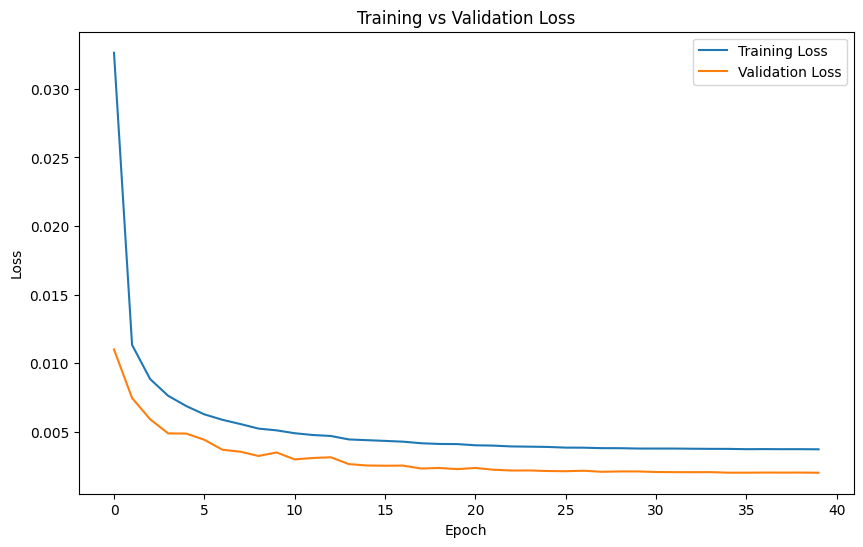

In [11]:
#Training vs Validation Loss

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [8]:
testgen = datagenerator(mnist_x_test,fashion_mnist_x_test,1000)

eval_samples_x, (eval_samples_y1, eval_sample2) = next(testgen)

def eval_model(model):
  with tf.device('/CPU:0'):
      x, (y1,y2) = next(testgen)

      # use model.predict to get predictions. Here we just call model
      pred1,pred2 = model(x)

  return (np.mean((pred1-y1)**2) + np.mean((pred2-y2)**2) / 2)


repeat_eval = 10
eval_results = []

for i in range(repeat_eval):
  eval_results.append(eval_model(model))

print("mse = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))


mse =  0.0015147798229008913
standard deviation =  3.9415825320704385e-05


In [9]:
def compute_pixel_accuracy(y_true, y_pred, threshold=0.01):
    """
    Calcola la percentuale di pixel in cui la differenza assoluta
    tra y_true e y_pred è inferiore a threshold.
    """
    # Calcola la differenza assoluta per ogni pixel
    diff = np.abs(y_true - y_pred)
    # Conta i pixel "corretti"
    correct_pixels = diff < threshold
    # Restituisce la media (percentuale di pixel corretti)
    return np.mean(correct_pixels)


def evaluate_accuracy(model, data_gen, steps=200, threshold=0.01):
    """
    Valuta l'"accuracy" del modello su un numero di batch presi dal data generator.
    Ritorna l'accuracy media per il ramo MNIST e per il ramo Fashion.
    """
    acc_mnist_list = []
    acc_fashion_list = []

    for _ in range(steps):
        x, (y_mnist, y_fashion) = next(data_gen)
        # Ottieni le ricostruzioni dal modello
        y_mnist_pred, y_fashion_pred = model.predict(x, verbose=0)
        # Calcola l'accuracy per ciascun ramo
        acc_mnist = compute_pixel_accuracy(y_mnist, y_mnist_pred, threshold)
        acc_fashion = compute_pixel_accuracy(y_fashion, y_fashion_pred, threshold)
        acc_mnist_list.append(acc_mnist)
        acc_fashion_list.append(acc_fashion)

    mean_acc_mnist = np.mean(acc_mnist_list)
    mean_acc_fashion = np.mean(acc_fashion_list)

    return mean_acc_mnist, mean_acc_fashion


val_gen_for_accuracy = datagenerator(mnist_x_test, fashion_mnist_x_test, batchsize=100)
acc_mnist, acc_fashion = evaluate_accuracy(model, val_gen_for_accuracy, steps=200, threshold=0.1)

print("Accuracy media (MNIST):", acc_mnist)
print("Accuracy media (Fashion):", acc_fashion)
print("Accuracy media complessiva:", (acc_mnist + acc_fashion) / 2)


Accuracy media (MNIST): 0.9802001464843749
Accuracy media (Fashion): 0.981263330078125
Accuracy media complessiva: 0.9807317382812499


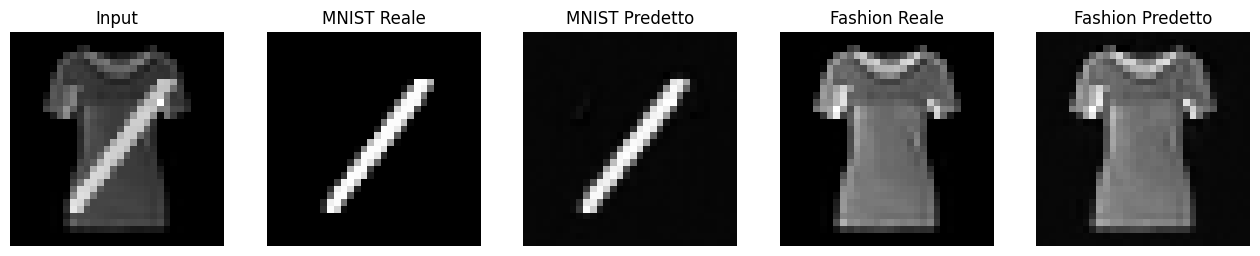

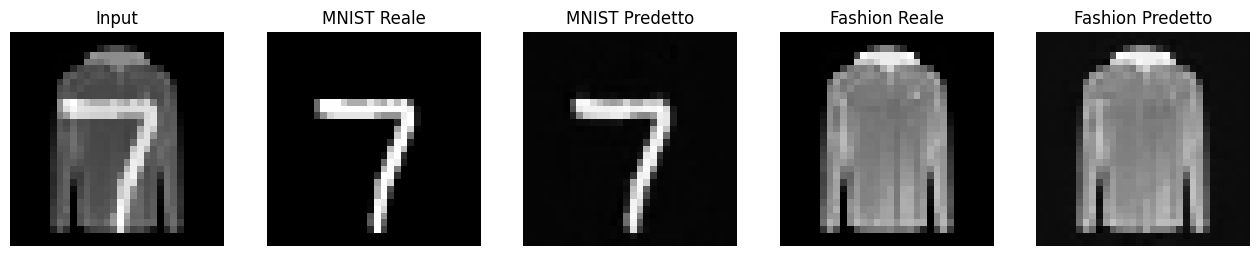

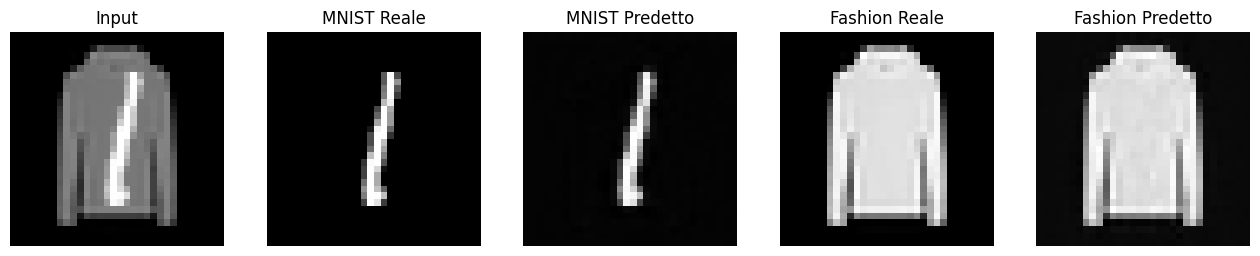

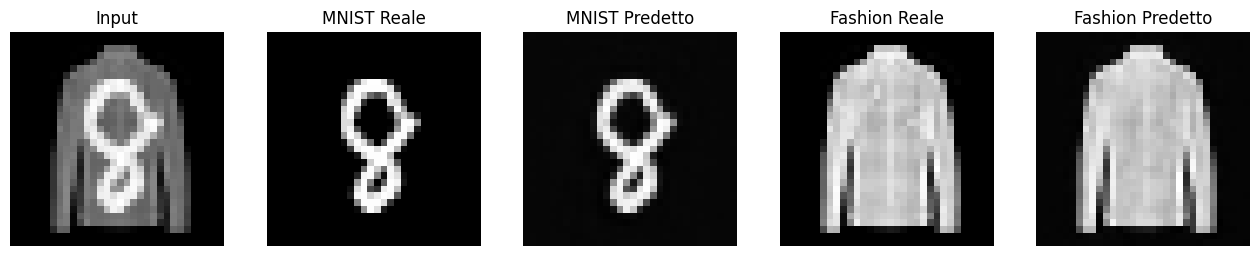

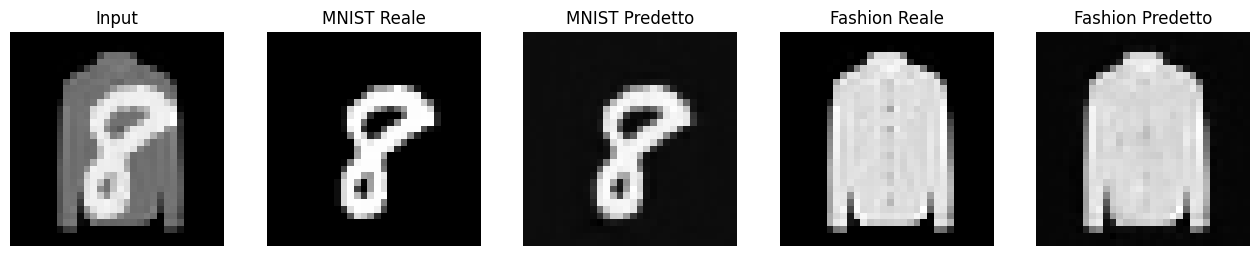

In [13]:
def plot_predictions(model, num_examples=5):
    """Visualizza input combinato e ricostruzioni"""
    # Utilizziamo il dataset corretto: fashion_mnist_x_test
    test_gen = datagenerator(mnist_x_test, fashion_mnist_x_test, 1)

    for _ in range(num_examples):
        x, (y1_true, y2_true) = next(test_gen)
        y1_pred, y2_pred = model.predict(x, verbose=0)

        plt.figure(figsize=(16, 4))
        # Input combinato
        plt.subplot(1, 5, 1)
        plt.imshow(x[0], cmap='gray')
        plt.title('Input')
        plt.axis('off')
        # MNIST Reale
        plt.subplot(1, 5, 2)
        plt.imshow(y1_true[0], cmap='gray')
        plt.title('MNIST Reale')
        plt.axis('off')
        # MNIST Predetto
        plt.subplot(1, 5, 3)
        plt.imshow(y1_pred[0], cmap='gray')
        plt.title('MNIST Predetto')
        plt.axis('off')
        # Fashion Reale
        plt.subplot(1, 5, 4)
        plt.imshow(y2_true[0], cmap='gray')
        plt.title('Fashion Reale')
        plt.axis('off')
        # Fashion Predetto
        plt.subplot(1, 5, 5)
        plt.imshow(y2_pred[0], cmap='gray')
        plt.title('Fashion Predetto')
        plt.axis('off')
        plt.show()

# Mostra esempi
plot_predictions(model)


In [12]:
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 32, 32, 1)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │            640 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 64)     │              0 │ leaky_re_lu_1[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 16, 16, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 16, 16, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 128)      │              0 │ leaky_re_lu_3[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)    

 Total params: 4,450,952 (16.98 MB)

 Trainable params: 1,483,138 (5.66 MB)

 Non-trainable params: 1,536 (6.00 KB)

 Optimizer params: 2,966,278 (11.32 MB)

None
